# Perkenalan

## Latar Belakang
- Terdapat dua aplikasi pesanan taksi online terkenal di New York, Amerika yaitu Uber dan Lyft. Tentunya kedua aplikasi tersebut akan memberikan harga yang bersaing untuk dipilih oleh konsumennya. Hal ini menimbulkan beberapa pertanyaan:
    - apakah terdapat perbedaan harga yang signifikan dari kedua aplikasi tersebut ?
    - faktor apa saja yang digunakan dari kedua aplikasi tersebut dalam menentukan harga?

## Data
- data yang digunakan bersumber dari kaggle dengan judul 'Uber and Lyft Dataset Boston, MA' yang berisi 57 kolom dengan 693071 baris. Kolom terdiri dari beberapa fitur yang dapat dipertimbangkan untuk penentuan harga dari kedua aplikasi tersebut yaitu distance, cab_type, timestamp, cuaca, suhu, dan masih banyak lagi. 
- data ini merupakan data pemesanan taksi online oleh pelanggan yang dikumpulkan pada 26 November - 19 Desember 2018.
- secara garis besar untuk menentukan perbandingan harga antara Lyft dan Uber akan dilakukan pemisahan dataset antara kedua aplikasi tersebut dan membandingkannya dengan faktor - faktor yang berpengaruh sangat signifikan dengan penentuan harganya.

## Tujuan
- diharapkan nantinya dapat diperoleh perbandingan harga antara Lyft dan Uber, faktor apa saja yang mempengaruhi penentuan harga, serta cara penentuan harga dari kedua aplikasi tersebut dengan menggunakan model regresi linear

# Import Pustaka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Data Loading

In [2]:
#memuat data yang akan digunakan
df= pd.read_csv('rideshare_kaggle.csv', low_memory=False)
pd.set_option('display.max_columns', None)
df.head(2)
df.shape

(693071, 57)

- data terdiri dari 57 kolom dengan 693071 data pesanan atau baris

In [3]:
# mengecek nilai baris yang terduplikasi
df[df.duplicated()]

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,short_summary,long_summary,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,icon,dewPoint,pressure,windBearing,cloudCover,uvIndex,visibility.1,ozone,sunriseTime,sunsetTime,moonPhase,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime


- tidak ada baris yang sama

In [4]:
# mengecek data yang hilang pada kolom
df.columns[df.isnull().any()]

Index(['price'], dtype='object')

- terdapat data yang hilang pada kolom 'price'

In [5]:
# pada kolom 'price' terdapat data yang hilang
# menghapus baris dengan nilai 'price' yang hilang
print("data 'price' yang hilang : ", sum(np.isnan(df['price'])))
df.dropna(inplace=True)
print(df.shape)

data 'price' yang hilang :  55095
(637976, 57)


- terdapat 55095 data kosong yang nanti akan mengganggu nilai regresi linear. data yang kosong ini di drop dari data set

In [6]:
print('jam :', (sorted(df.hour.unique())))
print('bulan :', (sorted(df.month.unique())))
print('tanggal :', (sorted(df.day.unique())))

jam : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
bulan : [11, 12]
tanggal : [1, 2, 3, 4, 9, 10, 13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30]


- data yang dicatat selama 24 jam
- dicatat selama 2 bulan yaitu bulan november dan desember. Maka dapat dianggap bahwa bulan pemesanan tidak berpengaruh pada nilai 'price'
- data tidak dicatat setiap hari karena ada tanggal yang tidak disebutkan pada data

In [7]:
pd.crosstab(df.surge_multiplier, df.cab_type)

cab_type,Lyft,Uber
surge_multiplier,,
1.00,286433,330568
1.25,11085,0
1.50,5065,0
1.75,2420,0
2.00,2239,0
2.50,154,0
3.00,12,0


- uber tidak terdapat catatan lonjakan penumpang

# Data Cleaning

In [8]:
# fitur pada dataset
print(df.columns)

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

- terdapat fitur - fitur yang memiliki kemiripan nama seperti time, temperatur, dan merupakan data yang tidak terikat dengan price, hal ini perlu kita selidiki lebih lanjut

In [9]:
# fitur timezone
print(df.timezone.unique())

['America/New_York']


- pada time zone hanya memiliki 1 data yang sama untuk semua pesanan, maka dapat disimpulkan bahwa fitur timezone tidak mempengaruhi 'price'

In [10]:
# fitur long_summary, short_summary, icon
print('long summary: ', df.long_summary.unique())
print('short summary: ', df.short_summary.unique())
print('icon: ', df.icon.unique())

long summary:  [' Rain throughout the day. '
 ' Rain until morning, starting again in the evening. '
 ' Light rain in the morning. ' ' Partly cloudy throughout the day. '
 ' Mostly cloudy throughout the day. '
 ' Light rain in the morning and overnight. '
 ' Light rain until evening. ' ' Foggy in the morning. '
 ' Overcast throughout the day. ' ' Possible drizzle in the morning. '
 ' Rain in the morning and afternoon. ']
short summary:  [' Mostly Cloudy ' ' Rain ' ' Clear ' ' Partly Cloudy ' ' Overcast '
 ' Light Rain ' ' Foggy ' ' Possible Drizzle ' ' Drizzle ']
icon:  [' partly-cloudy-night ' ' rain ' ' clear-night ' ' cloudy ' ' fog '
 ' clear-day ' ' partly-cloudy-day ']


- ketiga fitur tersebut memiliki kategoti yang hampir sama yaitu berkaitan dengan cuaca
- kita asumsikan bahwa ketiga fitur tersebut saling berhubungan dan dapat diwakili oleh satu fitur yaitu short_summary
- kita dapat menghapus fitur lainnya dari dataset

In [11]:
# fitur time
df1=df[['timestamp','windGustTime', 'temperatureHighTime','temperatureLowTime', 
              'apparentTemperatureHighTime','apparentTemperatureLowTime', 'sunriseTime',
              'sunsetTime','uvIndexTime','temperatureMinTime','temperatureMaxTime',
              'apparentTemperatureMinTime','apparentTemperatureMaxTime']]
print(df.shape)
df1.head(2)

(637976, 57)


,timestamp,windGustTime,temperatureHighTime,temperatureLowTime,apparentTemperatureHighTime,apparentTemperatureLowTime,sunriseTime,sunsetTime,uvIndexTime,temperatureMinTime,temperatureMaxTime,apparentTemperatureMinTime,apparentTemperatureMaxTime
0,1.544953e+09,1545015600,1544968800,1545048000,1544968800,1545044400,1544962084,1544994864,1544979600,1545012000,1544968800,1545012000,1544958000
1,1.543284e+09,1543291200,1543251600,1543298400,1543251600,1543291200,1543232969,1543266992,1543251600,1543233600,1543251600,1543291200,1543251600


<AxesSubplot:>

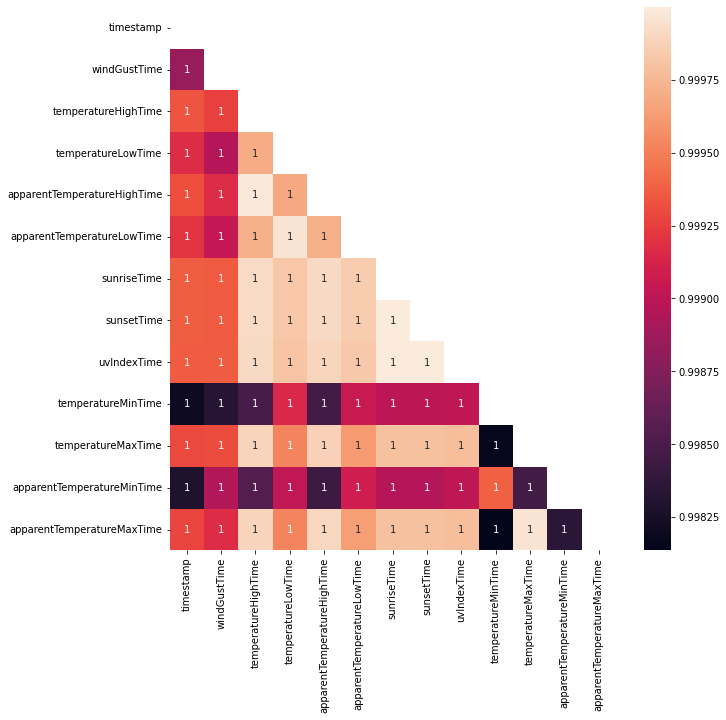

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(df1.corr(),annot=True, mask=np.triu(df1.corr()))

- fitur time ini memiliki korelasi yang besar satu sama lain
- selain itu kita tahu bahwa fitur time sudah diwakili dengan hour, day, month
- maka fitur time ini dapat di drop dari dataset

day


<Figure size 432x288 with 0 Axes>

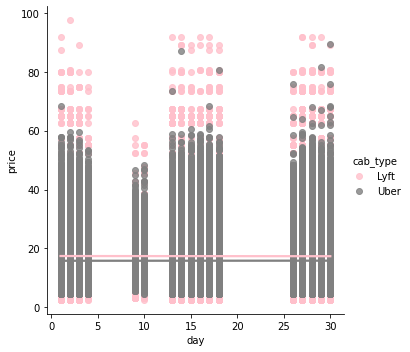

hour


<Figure size 432x288 with 0 Axes>

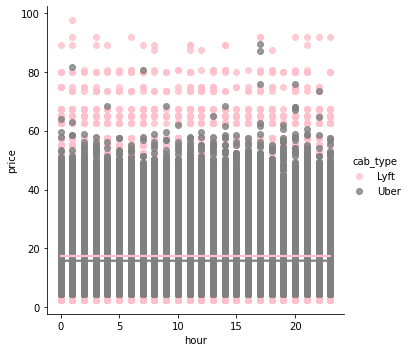

temperature


<Figure size 432x288 with 0 Axes>

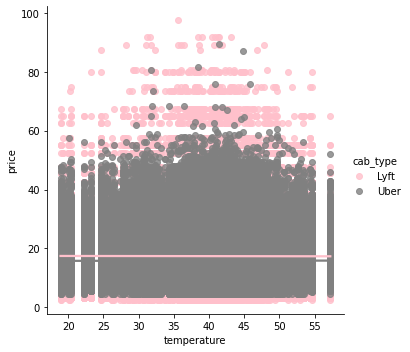

apparentTemperature


<Figure size 432x288 with 0 Axes>

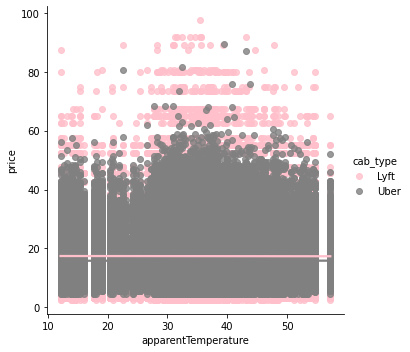

temperatureHigh


<Figure size 432x288 with 0 Axes>

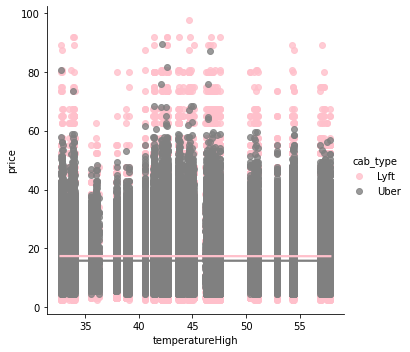

temperatureLow


<Figure size 432x288 with 0 Axes>

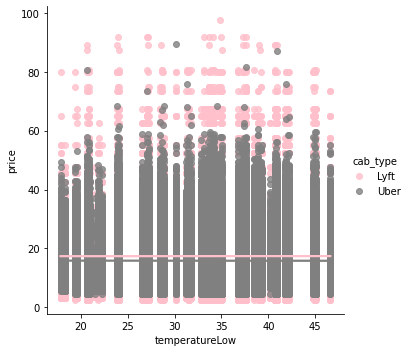

apparentTemperatureHigh


<Figure size 432x288 with 0 Axes>

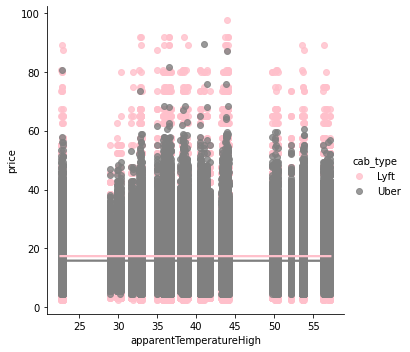

apparentTemperatureLow


<Figure size 432x288 with 0 Axes>

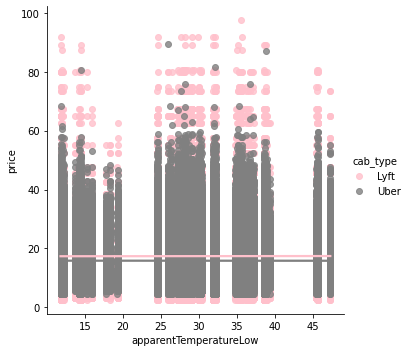

temperatureMin


<Figure size 432x288 with 0 Axes>

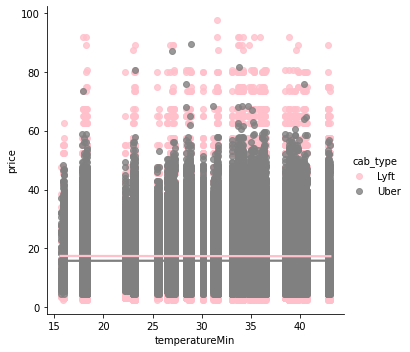

temperatureMax


<Figure size 432x288 with 0 Axes>

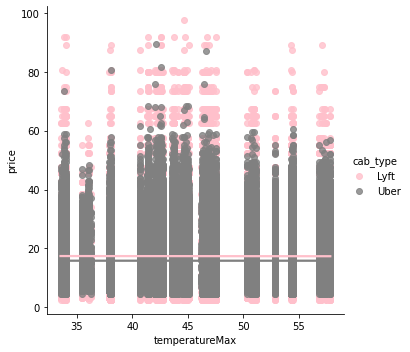

apparentTemperatureMin


<Figure size 432x288 with 0 Axes>

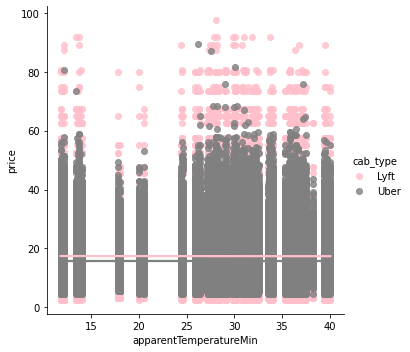

apparentTemperatureMax


<Figure size 432x288 with 0 Axes>

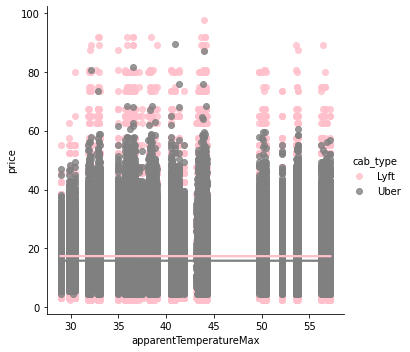

precipIntensity


<Figure size 432x288 with 0 Axes>

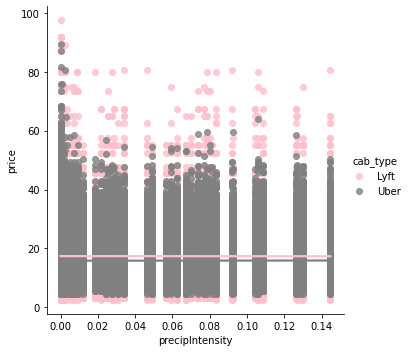

precipProbability


<Figure size 432x288 with 0 Axes>

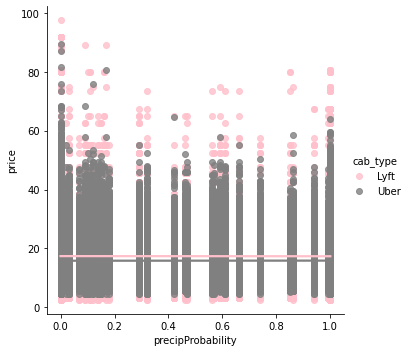

humidity


<Figure size 432x288 with 0 Axes>

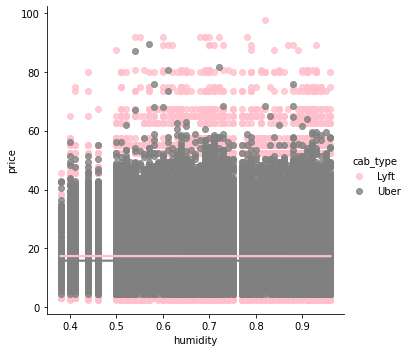

humidity


<Figure size 432x288 with 0 Axes>

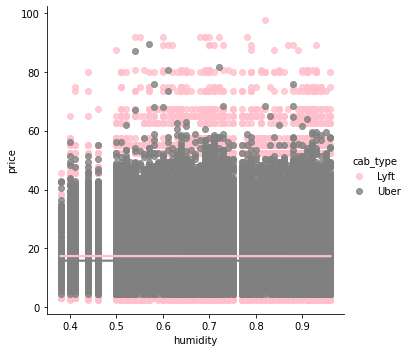

windSpeed


<Figure size 432x288 with 0 Axes>

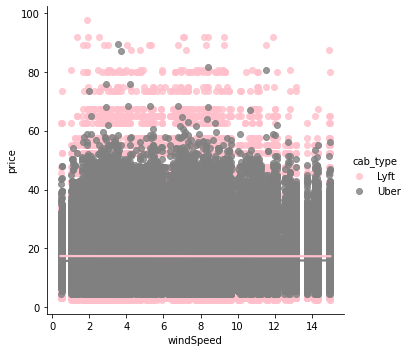

windGust


<Figure size 432x288 with 0 Axes>

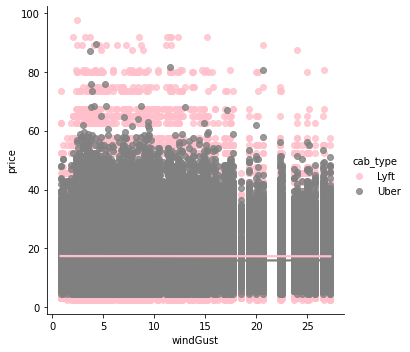

visibility


<Figure size 432x288 with 0 Axes>

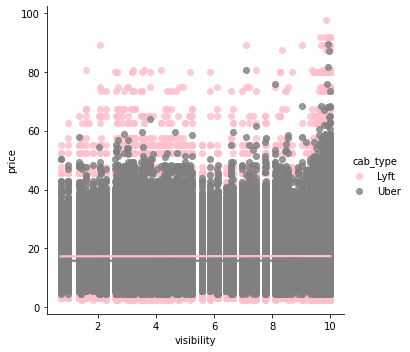

dewPoint


<Figure size 432x288 with 0 Axes>

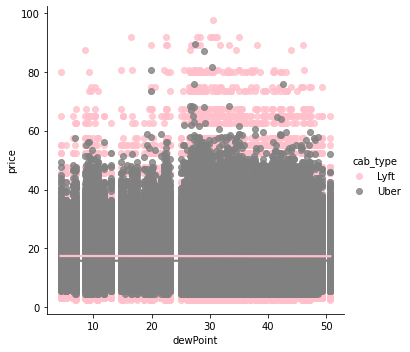

pressure


<Figure size 432x288 with 0 Axes>

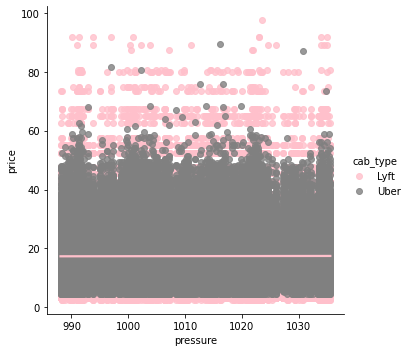

windBearing


<Figure size 432x288 with 0 Axes>

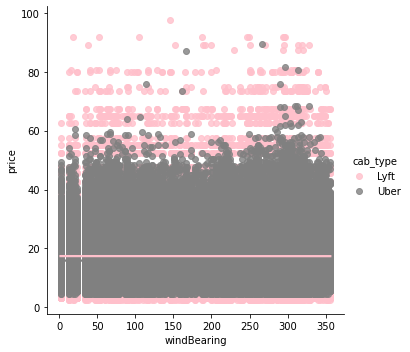

cloudCover


<Figure size 432x288 with 0 Axes>

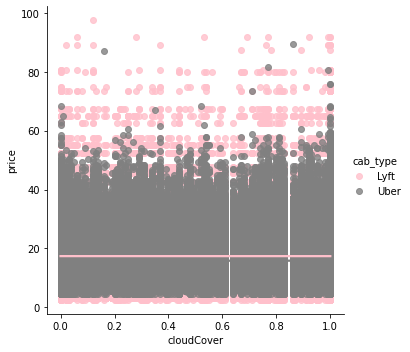

uvIndex


<Figure size 432x288 with 0 Axes>

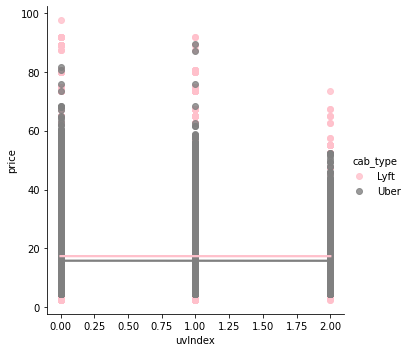

visibility.1


<Figure size 432x288 with 0 Axes>

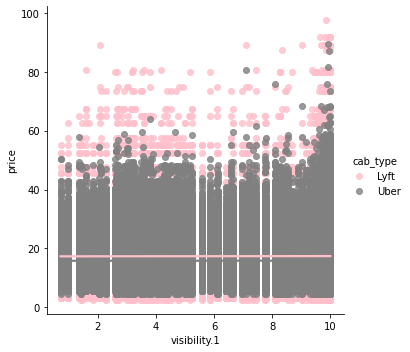

ozone


<Figure size 432x288 with 0 Axes>

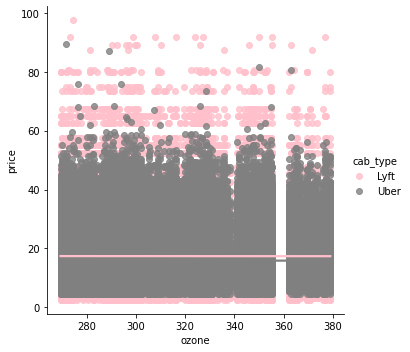

moonPhase


<Figure size 432x288 with 0 Axes>

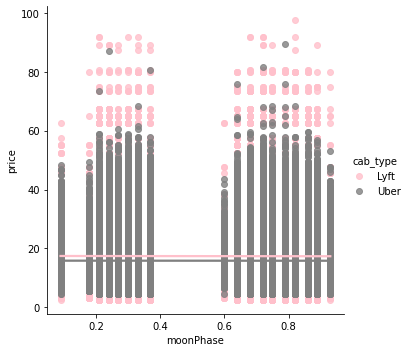

precipIntensityMax


<Figure size 432x288 with 0 Axes>

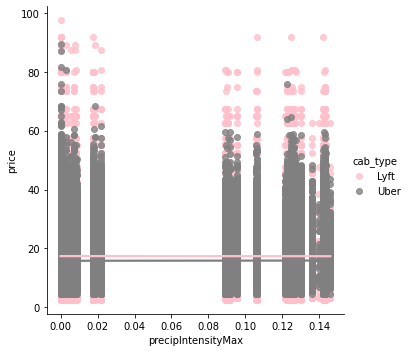

In [13]:
fitur = ['day','hour','temperature','apparentTemperature','temperatureHigh', 'temperatureLow',
            'apparentTemperatureHigh','apparentTemperatureLow','temperatureMin','temperatureMax',
            'apparentTemperatureMin','apparentTemperatureMax','precipIntensity','precipProbability',
            'humidity','humidity','windSpeed','windGust','visibility','dewPoint','pressure','windBearing',
            'cloudCover','uvIndex','visibility.1','ozone','moonPhase','precipIntensityMax']

custom_palette = ['pink', 'grey']
sns.set_palette(custom_palette)

for col in fitur:
    print(col)
    plt.figure()
    sns.lmplot(x=col, y='price', data=df, hue='cab_type', ci=None)
    plt.show()

- dari visualisasi dari beberapa fitur tidak memiliki kecenderungan kenaikan harga pada peningkatan nilai dari fitur atau bersifat konstan dan tidak memiliki keterikatan dengan 'price'
- hal ini menunjukan bahwa fitur yang disebutkan kita asumsikan tidak memiliki pengaruh padapenentuan nilai 'price'

In [14]:
# fitur id merupakan identitas dari setiap pesanan yang tidak terikat dengan 'price' 
# fitur latitude, longitude, source, destination yang kita asumsikan berhubungan dengan 'distance'
# fitur tersebut akan menentukan 'distance' yang ditempuh


In [15]:
# menghapus fitur yang tidak dibutuhkan
df = df.drop(['month','day','hour','datetime','timezone','long_summary','icon','timestamp','datetime',
                      'windGustTime', 'temperatureHighTime','temperatureLowTime', 'apparentTemperatureHighTime',
                      'apparentTemperatureLowTime', 'sunriseTime','sunsetTime','uvIndexTime','temperatureMinTime',
                      'temperatureMaxTime','apparentTemperatureMinTime','apparentTemperatureMaxTime',
                      'temperature','apparentTemperature','temperatureHigh', 'temperatureLow','apparentTemperatureHigh',
                      'apparentTemperatureLow','temperatureMin','temperatureMax','apparentTemperatureMin',
                      'apparentTemperatureMax','precipIntensity','precipProbability','humidity','humidity','windSpeed',
                      'windGust','visibility','dewPoint','pressure','windBearing','cloudCover','uvIndex','visibility.1','ozone',
                      'moonPhase','precipIntensityMax','id','source','destination','latitude','longitude'],axis=1)
print(df.shape)
df.head(2)

(637976, 7)


,cab_type,product_id,name,price,distance,surge_multiplier,short_summary
0,Lyft,lyft_line,Shared,5.0,0.44,1.0,Mostly Cloudy
1,Lyft,lyft_premier,Lux,11.0,0.44,1.0,Rain


- fitur - fitur yang tidak diperlukan dapat dihapus dari dataset untuk mempermudah kita dalam melakukan analisis nantinya

# Eksplorasi Data

In [16]:
# kategori yang ada pada setiap kolom
kategori = df.select_dtypes(include=['object','category']).columns.tolist()
for col in kategori:
    print(f'{col} : {df[col].unique()}')
    print()

cab_type : ['Lyft' 'Uber']

product_id : ['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus' 'lyft_lux'
 '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6c84fd89-3f11-4782-9b50-97c468b19529'
 '55c66225-fbe7-4fd5-9072-eab1ece5e23e'
 '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '997acbb5-e102-41e1-b155-9df7de0a73f2']

name : ['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']

short_summary : [' Mostly Cloudy ' ' Rain ' ' Clear ' ' Partly Cloudy ' ' Overcast '
 ' Light Rain ' ' Foggy ' ' Possible Drizzle ' ' Drizzle ']



In [17]:
# menamai ulang kolom dari dataset sesuai dengan nilai dalam kolom
df.rename({"cab_type": "merk", "name": "tipe", "short_summary": "cuaca",
                     "surge_multiplier":"lonjakan", "price":"harga",'distance':'jarak' }, 
                     axis=1, inplace=True)
df.head(2)

,merk,product_id,tipe,harga,jarak,lonjakan,cuaca
0,Lyft,lyft_line,Shared,5.0,0.44,1.0,Mostly Cloudy
1,Lyft,lyft_premier,Lux,11.0,0.44,1.0,Rain


In [18]:
# membagi dataset sesuai dengan merk yaitu Lyft dan Uber
df_lyft = df[:][df.merk == "Lyft"]
df_uber = df[:][df.merk == "Uber"]

In [19]:
# analisis kesamaan product_id dan tipe taksi untuk merk lyft
pd.crosstab(df_lyft.product_id,df_lyft.tipe)

tipe,Lux,Lux Black,Lux Black XL,Lyft,Lyft XL,Shared
product_id,,,,,,
lyft,0,0,0,51235,0,0
lyft_line,0,0,0,0,0,51233
lyft_lux,0,51235,0,0,0,0
lyft_luxsuv,0,0,51235,0,0,0
lyft_plus,0,0,0,0,51235,0
lyft_premier,51235,0,0,0,0,0


In [20]:
# analisis kesamaan product_id dan tipe taksi untuk merk uber
pd.crosstab(df_uber.product_id,df_uber.tipe)

tipe,Black,Black SUV,UberPool,UberX,UberXL,WAV
product_id,,,,,,
55c66225-fbe7-4fd5-9072-eab1ece5e23e,0,0,0,55094,0,0
6c84fd89-3f11-4782-9b50-97c468b19529,55095,0,0,0,0,0
6d318bcc-22a3-4af6-bddd-b409bfce1546,0,55096,0,0,0,0
6f72dfc5-27f1-42e8-84db-ccc7a75f6969,0,0,0,0,55096,0
997acbb5-e102-41e1-b155-9df7de0a73f2,0,0,55091,0,0,0
9a0e7b09-b92b-4c41-9779-2ad22b4d779d,0,0,0,0,0,55096


- product_id merupakan kode untuk setiap tipe taksi sehingga kita dapat menggunakan salah satu saja untuk analisis 

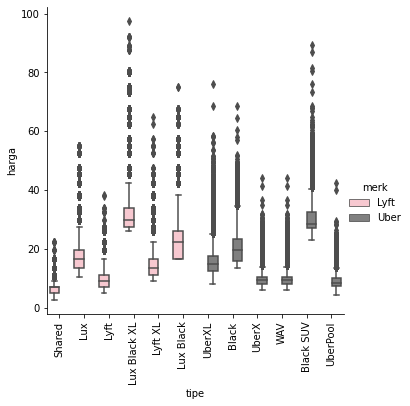

In [21]:
# pengaruh tipe taksi terhadap harga
ax = sns.catplot(x='tipe', y = 'harga', hue='merk', data=df, kind='box')
ax.set_xticklabels(rotation=90)
plt.show()

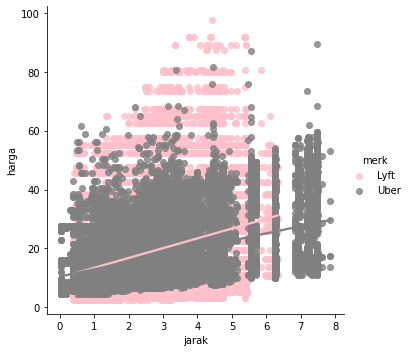

In [22]:
# pengaruh jarak terhadap harga
sns.lmplot(x='jarak', y='harga', hue='merk', data=df, ci=None)

<AxesSubplot:xlabel='harga', ylabel='merk'>

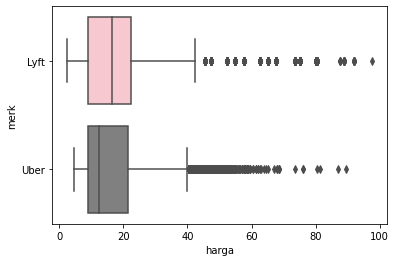

In [23]:
# pengaruh merk taksi terhadap harga
sns.boxplot(x='harga', y='merk', data=df, orient="h")

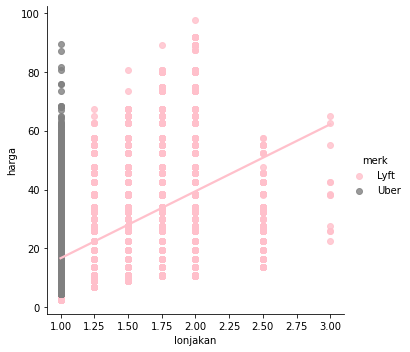

In [24]:
sns.lmplot(x='lonjakan', y='harga', hue='merk', data=df, ci=None)

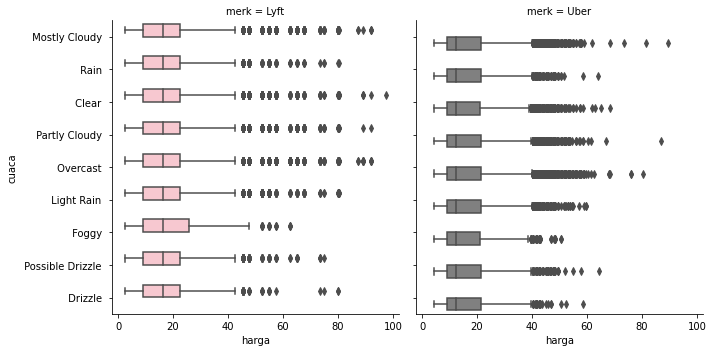

In [25]:
# pengaruh cuaca terhadap harga
sns.catplot(x="harga", y="cuaca", hue="merk", col="merk",data=df, kind="box")

- setelah dilakukan visualisasi terhadap fitur yang tersisa (merk, tipe, harga, jarak, dan cuaca) diketahui beberapa fitur tersebut memiliki hubungan dengan penentuan harga pada kedua merk
- fitur cuaca tidak memiliki hubungan yang signifikan dengan penentuan harga karena dari seluruh jenis cuaca memiliki nilai rata - rata harga yang sama , sehingga fitur cuaca dapat kita drop dataset
-  penentuan harga pada merk uber tidak dipengaruhi dengan nilai lonjakan karena pada dataset hanya diketahui 1 nilai lonjakan untuk seluruh pesanan di uber sehingga dapat di drop dari dataset uber

In [26]:
# menghapus fitur yang tidak dibutuhkan dari dataset
df.drop(['cuaca','product_id'],axis=1, inplace=True)
df_lyft.drop(['cuaca','product_id'],axis=1, inplace=True)
df_uber.drop(['cuaca','product_id'],axis=1, inplace=True)
print('dataset :', df.shape, 'lyft :', df_lyft.shape, 'uber :', df_uber.shape)

dataset : (637976, 5) lyft : (307408, 5) uber : (330568, 5)


# Data Preprocessing

In [28]:
# melabeli data yang akan digunakan
for i in df_lyft.tipe.unique():
    df_lyft[i] = (df_lyft.tipe == i).astype('int')

for i in df_uber.tipe.unique():
    df_uber[i] = (df_uber.tipe == i).astype('int')

In [29]:
print(df_lyft.columns)
df_lyft.head(2)

Index(['merk', 'tipe', 'harga', 'jarak', 'lonjakan', 'Shared', 'Lux', 'Lyft',
       'Lux Black XL', 'Lyft XL', 'Lux Black'],
      dtype='object')


,merk,tipe,harga,jarak,lonjakan,Shared,Lux,Lyft,Lux Black XL,Lyft XL,Lux Black
0,Lyft,Shared,5.0,0.44,1.0,1,0,0,0,0,0
1,Lyft,Lux,11.0,0.44,1.0,0,1,0,0,0,0


In [30]:
print(df_uber.columns)
df_uber.head(2)

Index(['merk', 'tipe', 'harga', 'jarak', 'lonjakan', 'UberXL', 'Black',
       'UberX', 'WAV', 'Black SUV', 'UberPool'],
      dtype='object')


,merk,tipe,harga,jarak,lonjakan,UberXL,Black,UberX,WAV,Black SUV,UberPool
12,Uber,UberXL,12.0,1.11,1.0,1,0,0,0,0,0
13,Uber,Black,16.0,1.11,1.0,0,1,0,0,0,0


In [34]:
# memilih data yang akan digunakan untuk proses modeling pada merk Lyft
X_lyft =df_lyft[[ 'jarak','lonjakan', 'Shared', 'Lux','Lux Black XL', 'Lyft XL', 'Lux Black']] #'Lyft' tidak diikutkan, digunakan sebagai baseline
y_lyft= df_lyft['harga']

train_X_lyft, test_X_lyft, train_y_lyft, test_y_lyft = train_test_split(X_lyft, y_lyft, test_size=0.2,random_state=325)

In [35]:
# memilih data yang akan digunakan untuk proses modeling pada merk Uber
X_uber = df_uber[[ 'jarak','UberXL', 'Black', 'WAV', 'Black SUV', 'UberPool']] #UberX digunakan sebagai baseline
y_uber=df_uber['harga']

train_X_uber, test_X_uber, train_y_uber, test_y_uber = train_test_split(X_uber , y_uber,test_size=0.2, random_state=325)

# Model

## Regresi Linear

R2 Regresi Linear Train: 0.9365
R2 Regresi Linear Test: 0.9363
RMSE Test Regresi Linear: 2.5324
Akurasi Regresi Linear: 84.99 %.


Text(0.5, 1.0, 'Perbedaan Harga Prediksi dan Asli pada Lyft dengan Regresi Linear')

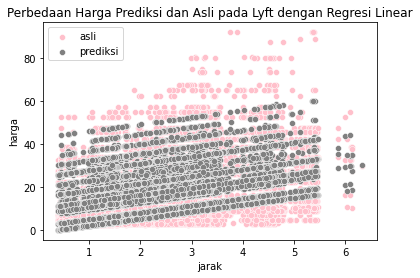

In [36]:
# Regresi Linear untuk Lyft

# Mendefinisikan model
lr = LinearRegression() 

# Fit model
lr_model_lyft = lr.fit(train_X_lyft, train_y_lyft)
pred_y_lyft = lr_model_lyft .predict(test_X_lyft)

# Menampilkan hasil uji
r2_lr_train_lyft = lr.score(train_X_lyft, train_y_lyft)
print('R2 Regresi Linear Train: %.4f' % r2_lr_train_lyft)

r2_lr_test_lyft = lr.score(test_X_lyft, test_y_lyft)
print('R2 Regresi Linear Test: %.4f' % r2_lr_test_lyft)

mse_lr_lyft = mean_squared_error(pred_y_lyft, test_y_lyft)
mse_lr_lyft = np.sqrt(mse_lr_lyft)
print('RMSE Test Regresi Linear: %.4f' % mse_lr_lyft)

errors_lyft = abs(pred_y_lyft-test_y_lyft)
mape_lyft = 100 * (errors_lyft  / test_y_lyft)
akurasi_lr_lyft = 100 - np.mean(mape_lyft)
print('Akurasi Regresi Linear:', round(akurasi_lr_lyft, 2), '%.')

# Membuat scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=test_X_lyft.jarak, y=test_y_lyft, ax=ax)
sns.scatterplot(x=test_X_lyft.jarak, y=pred_y_lyft, ax=ax)
plt.legend(labels=["asli","prediksi"])
plt.title("Perbedaan Harga Prediksi dan Asli pada Lyft dengan Regresi Linear")

In [37]:
coef_lr_lyft = pd.concat([pd.Series(X_lyft.columns), pd.Series(lr_model_lyft.coef_)], axis=1)
coef_lr_lyft.columns = ['Variable','Coefficient']
coef_lr_lyft.transpose()

,0,1,2,3,4,5,6
Variable,jarak,lonjakan,Shared,Lux,Lux Black XL,Lyft XL,Lux Black
Coefficient,3.241333,18.16162,-2.894578,8.174127,22.729016,5.702259,13.478355


R2 Regresi Linear Train: 0.9200
R2 Regresi Linear Test: 0.9188
RMSE Test Regresi Linear: 2.4425
Akurasi Regresi Linear: 88.13 %.


Text(0.5, 1.0, 'Perbedaan Harga Prediksi dan Asli pada Uber dengan Regresi Linear')

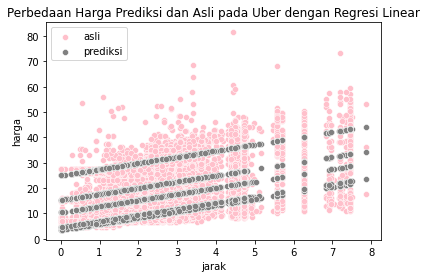

In [38]:
# Regresi Linear untuk Uber

# Mendefinisikan model
lr = LinearRegression() 

# Fit model
lr_model_uber = lr.fit(train_X_uber, train_y_uber)
pred_y_uber = lr_model_uber.predict(test_X_uber)

# Menampilkan hasil uji
r2_lr_train_uber = lr.score(train_X_uber, train_y_uber)
print('R2 Regresi Linear Train: %.4f' % r2_lr_train_uber )

r2_lr_test_uber = lr.score(test_X_uber, test_y_uber)
print('R2 Regresi Linear Test: %.4f' % r2_lr_test_uber)

mse_lr_uber = mean_squared_error(pred_y_uber, test_y_uber)
mse_lr_uber = np.sqrt(mse_lr_uber)
print('RMSE Test Regresi Linear: %.4f' % mse_lr_uber)

errors_uber = abs(pred_y_uber-test_y_uber)
mape_uber = 100 * (errors_uber / test_y_uber)
akurasi_lr_uber = 100 - np.mean(mape_uber)
print('Akurasi Regresi Linear:', round(akurasi_lr_uber, 2), '%.')

# Membuat scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=test_X_uber.jarak, y=test_y_uber, ax=ax)
sns.scatterplot(x=test_X_uber.jarak, y=pred_y_uber, ax=ax)
plt.legend(labels=["asli","prediksi"])
plt.title("Perbedaan Harga Prediksi dan Asli pada Uber dengan Regresi Linear")

In [39]:
coef_lr_uber = pd.concat([pd.Series(X_uber.columns), pd.Series(lr_model_uber.coef_)], axis=1)
coef_lr_uber.columns = ['Variable','Coefficient']
coef_lr_uber.transpose()

,0,1,2,3,4,5
Variable,jarak,UberXL,Black,WAV,Black SUV,UberPool
Coefficient,2.441057,5.89711,10.7592,-0.00273,20.50829,-1.012161


# LASSO

LASSO alpha : 0.003923518277292399
R2 LASSO Train: 0.9365
R2 LASSO Test: 0.9363
RMSE test LASSO: 2.5329
Akurasi LASSO: 85.07 %.


Text(0.5, 1.0, 'Perbedaan Harga Prediksi dan Asli pada Lyft dengan LASSO')

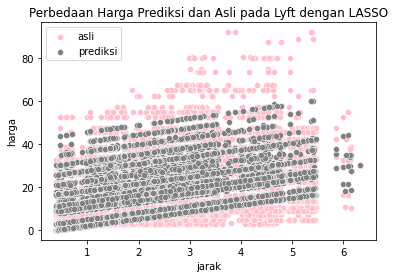

In [40]:
# LASSO untuk Lyft
#cv
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# definisi model
lasso_model_lyft = LassoCV(cv=cv)

#fit model
lasso_model_lyft.fit(train_X_lyft, train_y_lyft)
pred_y_lyft =lasso_model_lyft.predict(test_X_lyft)

# menampilkan lamda yang memproduksi MSE test paling kecil 
print('LASSO alpha :', lasso_model_lyft.alpha_)

# menampilkan hasil uji
r2_lasso_train_lyft = lasso_model_lyft.score(train_X_lyft, train_y_lyft)
print('R2 LASSO Train: %.4f' % r2_lasso_train_lyft )

r2_lasso_test_lyft = lasso_model_lyft.score(test_X_lyft, test_y_lyft)
print('R2 LASSO Test: %.4f' % r2_lasso_test_lyft)

mse_lasso_lyft = mean_squared_error(pred_y_lyft, test_y_lyft)
mse_lasso_lyft = np.sqrt(mse_lasso_lyft)
print('RMSE test LASSO: %.4f' % mse_lasso_lyft)

errors = abs(pred_y_lyft-test_y_lyft)
mape = 100 * (errors / test_y_lyft)
akurasi_lasso_lyft = 100 - np.mean(mape)
print('Akurasi LASSO:', round(akurasi_lasso_lyft, 2), '%.')

# Membuat scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=test_X_lyft.jarak, y=test_y_lyft, ax=ax)
sns.scatterplot(x=test_X_lyft.jarak, y=pred_y_lyft, ax=ax)
plt.legend(labels=["asli","prediksi"])
plt.title("Perbedaan Harga Prediksi dan Asli pada Lyft dengan LASSO")

In [41]:
coef_lasso_lyft = pd.concat([pd.Series(X_lyft.columns), pd.Series(lasso_model_lyft.coef_)], axis=1)
coef_lasso_lyft.columns = ['Variable','Coefficient']
coef_lasso_lyft.transpose()

,0,1,2,3,4,5,6
Variable,jarak,lonjakan,Shared,Lux,Lux Black XL,Lyft XL,Lux Black
Coefficient,3.238949,17.954535,-2.951918,8.077536,22.632656,5.606349,13.382411


LASSO alpha : 0.0033933817828505916
R2 LASSO Train: 0.9200
R2 LASSO Test: 0.9187
RMSE test LASSO: 2.4428
Akurasi LASSO: 88.16 %.


Text(0.5, 1.0, 'Perbedaan Harga Prediksi dan Asli pada Uber dengan LASSO')

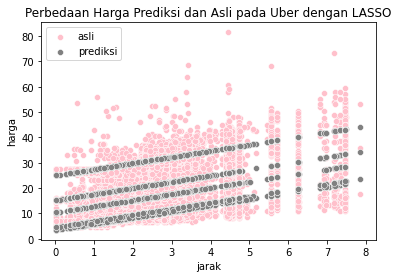

In [42]:
# LASSO untuk Uber
#cv
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#definisi model
lasso_model_uber = LassoCV(cv=cv)

#fit model
lasso_model_uber.fit(train_X_uber, train_y_uber)
pred_y_uber =lasso_model_uber.predict(test_X_uber)

#menampilkan lamda yang akan membuat RMSE paling rendah
print('LASSO alpha :', lasso_model_uber.alpha_)

#menampilkan hasil uji
r2_lasso_train_uber = lasso_model_uber.score(train_X_uber, train_y_uber)
print('R2 LASSO Train: %.4f' % r2_lasso_train_uber )

r2_lasso_test_uber = lasso_model_uber.score(test_X_uber, test_y_uber)
print('R2 LASSO Test: %.4f' % r2_lasso_test_uber)

mse_lasso_uber = mean_squared_error(pred_y_uber, test_y_uber)
mse_lasso_uber = np.sqrt(mse_lasso_uber)
print('RMSE test LASSO: %.4f' % mse_lasso_uber)

errors = abs(pred_y_uber-test_y_uber)
mape = 100 * (errors / test_y_uber)
akurasi_lasso_uber = 100 - np.mean(mape)
print('Akurasi LASSO:', round(akurasi_lasso_uber, 2), '%.')

# Membuat scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=test_X_uber.jarak, y=test_y_uber, ax=ax)
sns.scatterplot(x=test_X_uber.jarak, y=pred_y_uber, ax=ax)
plt.legend(labels=["asli","prediksi"])
plt.title("Perbedaan Harga Prediksi dan Asli pada Uber dengan LASSO")

In [43]:
coef_lasso_uber = pd.concat([pd.Series(X_uber.columns), pd.Series(lasso_model_uber.coef_)], axis=1)
coef_lasso_uber.columns = ['Variable','Coefficient']
coef_lasso_uber.transpose()

,0,1,2,3,4,5
Variable,jarak,UberXL,Black,WAV,Black SUV,UberPool
Coefficient,2.438626,5.854237,10.71652,-0.004495,20.46595,-1.013695


## Gradient Boosting

R2 Gradient Boosting Regressor Train: 0.9721
R2 Gradient Boosting Regressor Test: 0.9721
Gradient Boosting RMSE: 2.5329
Akurasi Gradient Boosting: 85.07 %.


Text(0.5, 1.0, 'Perbedaan Harga Prediksi dan Asli pada Lyft dengan Regresi Linear')

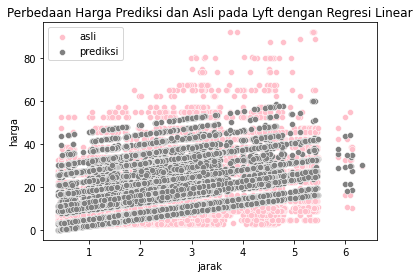

In [44]:
# GBR untuk lyft

# mendefinisikan model
gbr_lyft = ensemble.GradientBoostingRegressor()

# fit model
gbr_lyft.fit(train_X_lyft, train_y_lyft)

# menampilkan hasil uji
r2_gbr_train_lyft = gbr_lyft.score(train_X_lyft, train_y_lyft)
print('R2 Gradient Boosting Regressor Train: %.4f' % r2_gbr_train_lyft )

r2_gbr_test_lyft  = gbr_lyft.score(test_X_lyft, test_y_lyft)
print('R2 Gradient Boosting Regressor Test: %.4f' % r2_gbr_test_lyft)

y_pred = gbr_lyft.predict(test_X_lyft)
mse_gbr_lyft = mean_squared_error(pred_y_lyft, test_y_lyft)
mse_gbr_lyft = np.sqrt(mse_gbr_lyft)
print('Gradient Boosting RMSE: %.4f' % mse_gbr_lyft)

errors_lyft = abs(pred_y_lyft-test_y_lyft)
mape_lyft = 100 * (errors_lyft  / test_y_lyft)
akurasi_gbr_lyft = 100 - np.mean(mape_lyft)
print('Akurasi Gradient Boosting:', round(akurasi_gbr_lyft, 2), '%.')

# Membuat scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=test_X_lyft.jarak, y=test_y_lyft, ax=ax)
sns.scatterplot(x=test_X_lyft.jarak, y=pred_y_lyft, ax=ax)
plt.legend(labels=["asli","prediksi"])
plt.title("Perbedaan Harga Prediksi dan Asli pada Lyft dengan Regresi Linear")

R2 Gradient Boosting Regressor Train: 0.9475
R2 Gradient Boosting Regressor Test: 0.9461
Gradient Boosting RMSE: 2.4428
Akurasi Gradient Boosting: 88.16 %.


Text(0.5, 1.0, 'Perbedaan Harga Prediksi dan Asli pada uber dengan Regresi Linear')

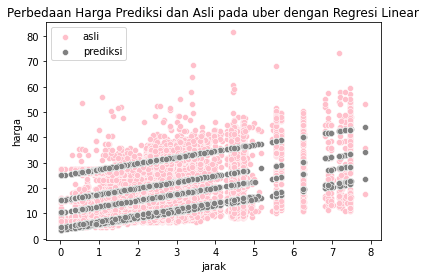

In [45]:
# GBR untuk uber

# mendefinisikan model
gbr_uber= ensemble.GradientBoostingRegressor()

# fit model
gbr_uber.fit(train_X_uber, train_y_uber)

# menampilkan hasil uji
r2_gbr_train_uber = gbr_uber.score(train_X_uber, train_y_uber)
print('R2 Gradient Boosting Regressor Train: %.4f' % r2_gbr_train_uber )

r2_gbr_test_uber = gbr_uber.score(test_X_uber, test_y_uber)
print('R2 Gradient Boosting Regressor Test: %.4f' % r2_gbr_test_uber)

y_pred = gbr_uber.predict(test_X_uber)
mse_gbr_uber = mean_squared_error(pred_y_uber, test_y_uber)
mse_gbr_uber = np.sqrt(mse_gbr_uber)
print('Gradient Boosting RMSE: %.4f' % mse_gbr_uber)

errors_uber = abs(pred_y_uber-test_y_uber)
mape_uber = 100 * (errors_uber  / test_y_uber)
akurasi_gbr_uber = 100 - np.mean(mape_uber)
print('Akurasi Gradient Boosting:', round(akurasi_gbr_uber, 2), '%.')

# Membuat scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=test_X_uber.jarak, y=test_y_uber, ax=ax)
sns.scatterplot(x=test_X_uber.jarak, y=pred_y_uber, ax=ax)
plt.legend(labels=["asli","prediksi"])
plt.title("Perbedaan Harga Prediksi dan Asli pada uber dengan Regresi Linear")

# Evaluasi Model

In [46]:
lyft_data = {"Model": ["Regresi Linear", "LASSO", "Gradient Boosting"], 
"Train R2": [r2_lr_train_lyft,r2_lasso_train_lyft, r2_gbr_train_lyft],
"Test R2": [r2_lr_test_lyft,r2_lasso_test_lyft, r2_gbr_test_lyft],
"Test RMSE": [mse_lr_lyft,mse_lasso_lyft,mse_gbr_lyft],
"Accuracy": [akurasi_lr_lyft, akurasi_lasso_lyft, akurasi_gbr_lyft]}

uber_data = {"Model": ["Regresi Linear", "LASSO", "Gradient Boosting"], 
"Train R2": [r2_lr_train_uber,r2_lasso_train_uber, r2_gbr_train_uber],
"Test R2": [r2_lr_test_uber,r2_lasso_test_uber, r2_gbr_test_uber],
"Test RMSE": [mse_lr_uber, mse_lasso_uber,mse_gbr_uber],
"Accuracy": [akurasi_lr_uber, akurasi_lasso_uber, akurasi_gbr_uber]}

tabel_ringkasan_lyft = pd.DataFrame(lyft_data)
print('Ringkasan Evaluasi Model pada Lyft')
display(tabel_ringkasan_lyft)
tabel_ringkasan_uber = pd.DataFrame(uber_data)
print('Ringkasan Evaluasi Model pada Uber')
display(tabel_ringkasan_uber)

Ringkasan Evaluasi Model pada Lyft


,Model,Train R2,Test R2,Test RMSE,Accuracy
0,Regresi Linear,0.936488,0.936339,2.532369,84.991218
1,LASSO,0.936467,0.936314,2.532864,85.074202
2,Gradient Boosting,0.972095,0.972065,2.532864,85.074202


Ringkasan Evaluasi Model pada Uber


,Model,Train R2,Test R2,Test RMSE,Accuracy
0,Regresi Linear,0.920043,0.918765,2.442532,88.128357
1,LASSO,0.920037,0.918747,2.442811,88.155111
2,Gradient Boosting,0.947501,0.946112,2.442811,88.155111


In [47]:
print('Koefisien Lyft')
coef_lr_lyft.rename({'Variable':'Koefisien','Coefficient': 'LR'}, axis=1, inplace=True)
coef_lasso_lyft.rename({'Variable':'Koefisien','Coefficient': 'Lasso'}, axis=1, inplace=True)
coef_lasso_lyft.drop(['Koefisien'],axis=1,inplace=True)
koefisien_lyft =  pd.concat([coef_lr_lyft, coef_lasso_lyft], axis=1)
koefisien_lyft.transpose()

Koefisien Lyft


,0,1,2,3,4,5,6
Koefisien,jarak,lonjakan,Shared,Lux,Lux Black XL,Lyft XL,Lux Black
LR,3.241333,18.16162,-2.894578,8.174127,22.729016,5.702259,13.478355
Lasso,3.238949,17.954535,-2.951918,8.077536,22.632656,5.606349,13.382411


In [48]:
print('Koefisien Uber')
coef_lr_uber.rename({'Variable':'Koefisien','Coefficient': 'LR'}, axis=1, inplace=True)
coef_lasso_uber.rename({'Variable':'Koefisien','Coefficient': 'Lasso'}, axis=1, inplace=True)
coef_lasso_uber.drop(['Koefisien'],axis=1,inplace=True)
koefisien_uber=  pd.concat([coef_lr_uber, coef_lasso_uber], axis=1)
koefisien_uber.transpose()

Koefisien Uber


,0,1,2,3,4,5
Koefisien,jarak,UberXL,Black,WAV,Black SUV,UberPool
LR,2.441057,5.89711,10.7592,-0.00273,20.50829,-1.012161
Lasso,2.438626,5.854237,10.71652,-0.004495,20.46595,-1.013695


In [53]:
lasso_model_uber.predict([[1,0,0,0,0,0]])

/home/jefl5/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


array([6.88538594])

# Kesimpulan